# TAR PROJECT - TEXT SEGMENTATION

### Authors: Mirela Oštrek and Luka Dulčić

In [12]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
import string
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Helper functions

In [13]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stemmer = PorterStemmer()
# irrelevant characters specific for choi dataset
choi_noise = ['--', '\'\'', '``', ';', '..', '...', 'afj']

def is_digit(string):
    """
    Checks whether string is digit.
    :param string: String
    :return boolean: True if string is digit otherwise False.
    """
    return string.replace('.', '').replace('-', '').replace(',', '').isdigit()

def stem_tokens(tokens, stemmer):
    """
    Stemms tokens using Porter Stemmer.
    :param tokens: List of tokens.
    :param stemmer: Object which has method "stem" (in this poject it is nltk Porter Stemmer)
    :return list: List of stemmed tokens.
    """
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    """
    Tokenizes text.
    
    :param text: String.
    :return list: List of stemmed tokens from text.
    """
    tokens = nltk.word_tokenize(text)
    tokens = list(map(lambda t: t.lower(), tokens))
    tokens = filter(lambda t: t not in string.punctuation, tokens)
    tokens = filter(lambda t: t not in ENGLISH_STOP_WORDS, tokens)
    tokens = filter(lambda t: not is_digit(t), tokens)
    tokens = filter(lambda t: t not in choi_noise, tokens)
    tokens = filter(lambda t: t[0] != '\'', tokens)#remove strings like "'s" 
    stems = stem_tokens(tokens, stemmer)
    return stems

def get_filepaths(directory):
    """
    Recursively searches directory and returns all file paths.
    
    :param directory: Root directory.
    :return list: List of all files in directory and all of its subdirectories.
    """
    file_paths = []

    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    return file_paths

def doc_to_seg_string(n_sent, boundaries):
    """
    Creates string which represents documents (eg. '0000100001000')
    where 0 marks sentence and 1 marks boundary between segments.
    This string is used for evaluating topic tiling algorithm with Pk
    and WD measure.
    
    :param n_sent: Number of sentences in document.
    :param boundaries: Indices of boundaries between segments.
    :return string: String which represent document.
    """
    seg_string = ''
    for i in range(n_sent):
        if i in boundaries:
            seg_string += '1'
        else:
            seg_string += '0'
    return seg_string

def print_top_words(model, feature_names, n_top_words):
    """
    Prints top words for each topic where "model" is LDA model.
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def max_left(sequence, ind_curr):
    """
    Searches for maximum value in sequence starting from ind_curr to the left.
    
    :param sequence: List of integer values.
    :param ind_curr: Index from which search starts.
    :return integer: Maximum value from in sequence where index is less than ind_curr.
    """
    max = sequence[ind_curr]
    while (ind_curr != 0) and (max <= sequence[ind_curr-1]):
        max = sequence[ind_curr-1]
        ind_curr -= 1 
    return max

def max_right(sequence, ind_curr):
    """
    Searches for maximum value in sequence starting from ind_curr to the right.
    
    :param sequence: List of integer values.
    :param ind_curr: Index from which search starts.
    :return integer: Maximum value from in sequence where index is greater than ind_curr.
    """
    max = sequence[ind_curr]
    while (ind_curr != (len(sequence)-1)) and (max <= sequence[ind_curr+1]):
        max = sequence[ind_curr+1]
        ind_curr += 1  
    return max

### Document class

In [14]:
class Document:
    """
    Document represents one document.
    
    :param path: Path to file which contains document.
    :param sentences: list of document sentences
    :param boundaries: list of positions where segments boundaries are 
                        (note: boundary 0 means segment boundary is behind sentence at index 0)
    :param segment_divider: string which indicates boundary between two segments
    """
    
    def __init__(self, path):
        """
        :param path: Path to file where documents is.
        """
        self.path = path
        self.sentences = []
        self.boundaries = []
        self.segment_divider = "=========="
        
        self.load_document(path)
        
    def load_document(self, path):
        """
        Loads document from file.
        
        :param path: Path to file where document is.
        """
        sentences = self.get_valid_sentences(path)
        for i, sentence in enumerate(sentences):
            if sentence != self.segment_divider:
                self.sentences.append(sentence)
            else:
                self.boundaries.append(i - len(self.boundaries) - 1)
        #remove unecessary boundaries at beginning and the end
        del self.boundaries[0]
        del self.boundaries[-1]
        
    def get_valid_sentences(self, path):
        """
        Reads all sentences from file and filters out invalid ones.
        Invalid sentences are sentences which are empty or contain
        only irrelevant tokens like stop words, punctuations, etc.
        
        :param path: Path to file where document is.
        :return list: List of valid sentences.
        """
        sentences = []
        with open(path, 'r') as fd:
            for line in fd:
                line = line.rstrip('\n')
                if tokenize(line):
                    # if line is valid
                    sentences.append(line)
        return sentences
        
    
    def to_text(self):
        """
        Returns this documents as appendend string of sentences.
        """
        return '\n'.join(self.sentences)
    
    def to_segments(self):
        """
        Returns this document as list of segments based on boundaries.
        """
        segments = []
        for i, boundary in enumerate(self.boundaries):
            if i == 0:
                segments.append(' '.join(self.sentences[0:boundary]))
            else:
                last_b = self.boundaries[i - 1]
                segments.append(' '.join(self.sentences[last_b:boundary]))
        segments.append(' '.join(self.sentences[self.boundaries[-1]:]))
        return segments

## Loading dataset

In [83]:
files_paths = get_filepaths('choi_data')
documents = [Document(path) for path in files_paths]

## Topic Tiling class

In [99]:
from scipy import spatial
from scipy.signal import argrelextrema

class TopicTiling:
    """
    Implementation of Topic Tiling algorithm (M. Riedl and C. Biemann. 2012, Text Segmentation with Topic Models)
    
    :param m: Multiplier of standard deviation in condition for segmentation (c = mean - m*stddev).
    :param cosine_similarities: Cosine similarities between sentences.
    :param boundaries: Caluclated segments boundaries.

    """
    
    def __init__(self, m = 0.5):
        self.m = m
        self.cosine_similarities = None
        self.boundaries = None
        
    def fit(self, sentence_vectors):
        """
        Runs Topic Tiling algorithm on list of sentence vectors.
        
        :param sentence_vectors: List (iterable) of topic distributions for each sentence in document.
                                 t-th element of sentence vector is weight for t-th topic for sentence, 
                                 higher weight means that sentence is "more about" t-th topic.
                                 
        :return: Calculated boundaries based on similatities between sentence vectors.
                 Note: boundary '0' means that segment boundary is behind sentence which is at index 0
                 in sentence_vectors.
        """
        self.cosine_similarities = np.empty(0)
        depth_scores = []

        # calculating cosine similarities
        for i in range(0, len(sentence_vectors) - 1):
            sim = 1 - spatial.distance.cosine(sentence_vectors[i], sentence_vectors[i+1])
            self.cosine_similarities = np.append(self.cosine_similarities, sim)

        # get all local minima
        split_candidates_indices = argrelextrema(self.cosine_similarities, np.less_equal)[0]

        # calculating depth scores
        for i in split_candidates_indices:
            depth = 1/2 * (max_left(self.cosine_similarities, i) + max_right(self.cosine_similarities, i) - 2 * self.cosine_similarities[i])
            depth_scores.append((depth, i))

        tmp = np.array(list(map(lambda d: d[0], depth_scores)))
        
        # calculate segment threshold condition
        condition = tmp.mean() - self.m*tmp.std()
        
        # determine segment boundaries
        tmp = filter(lambda d: d[0] > condition, depth_scores)
        self.boundaries = [d[1] for d in tmp]
        
        return self.boundaries
    
    def set_m(self, m):
        """
        Setter for parameter m.
        """
        if m:
            self.m = m

## Segmentation Engine class

In [253]:
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.metrics.segmentation import pk
from nltk.metrics.segmentation import windowdiff
from time import time

class SegmentationEngine(BaseEstimator):
    """
    Implementation of segmentation engine used for segmenting documents.
    Based on Latent Dirichlet Allocation model and Topic Tiling algorithm.
    
    :param vectorizer: CountVectorizer class used for transforming and cleaning input data.
    :param lda: Latent Dirichlet Allocation model.
    :param tt: Topic Tiling class.
    :param n_topics: Number of topics parameter of LDA.
    :param max_iter: Maximum number of iterations parameter of LDA.
    :param a: Document topics prior parameter of LDA.
    :param b: Topic document prior parameter of LDA.
    :param m: Multiplier parameter of Topic Tiling
    :param random_state: Random state.
    """
    
    def __init__(self, n_topics = 10, max_iter = None, a = None, b = None, m = None, random_state = None):
        """
        Initializes estimator.
        """
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.a = a
        self.b = b
        self.m = m
        self.random_state = random_state
        
        self.vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=tokenize, stop_words='english')
        self.lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=max_iter, doc_topic_prior=a, topic_word_prior=b, random_state=random_state)
        self.tt = TopicTiling(m=m)
        
    def fit(self, documents):
        """
        Trains segmentation engine.
        
        :param documents: List (iterable) of documents (class Document). 
        """
        t0 = time()
        
        train_data = self.parse_data(documents)
        X = self.vectorizer.fit_transform(train_data)
        self.lda.fit(X)
        
        print('Fitted in %0.2f seconds' % (time() - t0))
        
    def predict(self, documents):
        """
        Calculates segment boundaries for documents.
        
        :param documents: List (iterable) of documents (class Document).
        :return: List of boundaries for each document.
        """
        # TODO check if fit has been called
        estimated_boundaries = []
        for document in documents:
            sentence_vectors = [self.lda.transform(self.vectorizer.transform([sentence])) for sentence in document.sentences]
            estimated_boundaries.append(self.tt.fit(sentence_vectors))
        return estimated_boundaries
    

    def score(self, X, method = 'pk'):
        """
        Calculates segmentation score with Pk or WindowDiff measure.
        
        :param X: List (iterable) of documents (class Document).
        :param method: String which indicates which evaluation method should be used.
                       Possible evaluation methods are Pk measure ('pk') or WindowDiff method ('wd').
                       By default Pk measure is used.
        :return float: Evaluation score (actually method returns 1 - pk or 1 - wd because standard 
                       scikit learn grid search treats higher values as better while the oposite is 
                       the case with pk and wd).
        """
        if method == 'wd':
            scorer = windowdiff
        else:
            scorer = pk
            
        scores = np.empty(0)
        estimated_boundaries = self.predict(X)
        for i, document in enumerate(X):            
            ref_doc = doc_to_seg_string(len(document.sentences), document.boundaries)
            estimated_doc = doc_to_seg_string(len(document.sentences), estimated_boundaries[i])
            # calculate k
            k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))
            scores = np.append(scores, scorer(ref_doc, estimated_doc, k))
        return 1 - scores.mean()    
                
                
    def set_params(self, **params):
        """
        Sets value of parameters.
        
        :param params: Dictionary of parameters to be set.
        """
        super(SegmentationEngine, self).set_params(**params)

        # refresh parameters
        self.lda.set_params(n_topics=self.n_topics, max_iter=self.max_iter, doc_topic_prior=self.a, topic_word_prior=self.b, random_state=self.random_state)
        self.tt.set_m(self.m)
        return self
        
    def parse_data(self, documents):
        """
        Transforms list of documents into list of segments.
        :param documents: List of documents (class Document)
        :return list: List of segments.
        """
        train_data = []
        for document in documents:
            train_data.extend(document.to_segments())
        return train_data

### Train-test split

In [174]:
from sklearn.cross_validation import train_test_split

X_train, X_test = train_test_split(documents, test_size = 0.2)

### Grid Search

### Optimizing parameters $K$, $\alpha$ and $x$

### WARNING! Very slow block

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

cv = ShuffleSplit(len(X_train), n_iter=1, test_size=.2)

engine = SegmentationEngine(max_iter=60, a=0.1, b=0.01)
params = {'n_topics': [60, 80, 100, 120, 130, 140, 150, 160], 'm': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 'a':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
clf = GridSearchCV(engine, params, cv=cv)

t = time()
clf.fit(X_train)
print('Duration %f hours' % ((time() - t)/3600))

In [254]:
clf.best_estimator_.score(X_test)

0.890670067939813


In [113]:
doc = list(filter(lambda d: d.path == 'choi_data/4/6-8/15.ref', X_test))

In [219]:
doc = X_test[77]
plot_indices = clf.best_estimator_.predict([doc])

### Graph

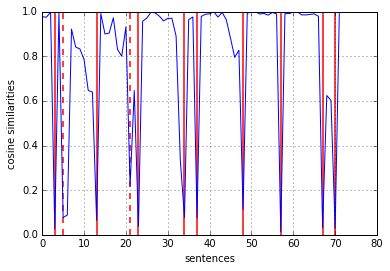

            Pk measure result 0.054795
            WD measure result 0.109589


In [252]:
import matplotlib.pyplot as plt

plt.vlines(plot_indices, 0, 1, 'r', linewidth=1.5)
plt.plot(range(0, len(clf.best_estimator_.tt.cosine_similarities)), clf.best_estimator_.tt.cosine_similarities)
plt.xlabel("sentences")
plt.ylabel("cosine similarities")
plt.grid()
plt.show()

ref_doc = doc_to_seg_string(len(doc.sentences), doc.boundaries)
estimated_doc = doc_to_seg_string(len(doc.sentences), plot_indices[0])
k = int(round(len(ref_doc) / (ref_doc.count('1') * 2.)))

print('Pk measure result %f' % pk(ref_doc, estimated_doc))
print('WD measure result %f' % windowdiff(ref_doc, estimated_doc, k))